# Word Tokenization with multiple Architectures

## Tensorflow Datasets: IMDB

In [87]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

In [25]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s, l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s, l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Tokenization Sequences

In [27]:
# Parameters
VOCAB_SIZE = 10000
MAX_LENGTH = 120
TRUNC_TYPE='post'
PADDING_TYPE='post'
OOV_TOK = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOK)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

## Pre-defined Embeddings

Global Vectors for Word Representation: https://nlp.stanford.edu/projects/glove/
glove.6B.zip: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

In [28]:
# Define path to file containing the embeddings
GLOVE_FILE = './glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [29]:
test_word = 'dog'
test_vector = GLOVE_EMBEDDINGS[test_word]
print(f"Each word vector has shape: {test_vector.shape}")
print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")


Each word vector has shape: (100,)
Vector representation of word dog looks like this:

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1

Save the vector representation of each word in the vocabulary in a numpy array.

In [51]:
from itertools import islice

list(islice(word_index.items(), 0, 5))

[('<OOV>', 1), ('the', 2), ('and', 3), ('a', 4), ('of', 5)]

In [57]:
# Embedding dimension
EMBEDDING_DIM=100

# word_index starts counting at 1, we need to add 1 to VOCAB_SIZE
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

for word, i in islice(word_index.items(), 0, VOCAB_SIZE):
    # print(word, i)
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

In [65]:
EMBEDDINGS_MATRIX

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [-0.46388   ,  0.56339002,  0.31219   , ...,  0.48800001,
        -0.064468  , -0.068283  ],
       [-0.13887   ,  1.09119999, -0.48866999, ...,  0.78184998,
         0.90399998,  0.38177001],
       [ 0.21997   , -0.1015    ,  0.37818   , ..., -0.35999   ,
        -0.117     ,  0.5625    ]])

## Dropout Model

In [54]:
def create_dropout_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    """
    Creates a binary sentiment classifier model
    Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
        embeddings_matrix (array): predefined weights of the embeddings
    Returns:
        model (tf.keras Model): the sentiment classifier model
    """
    # Hyper-parameters
    LSTM1_dim = 64
    Dense_dim = 64

    # Architecture
    model = tf.keras.Sequential([
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM1_dim)),
        tf.keras.layers.Dropout(0.9),
        tf.keras.layers.Dense(Dense_dim, activation='relu'),
        tf.keras.layers.Dropout(0.9),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Training parameters
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
# Model Parameters
NUM_EPOCHS = 10
BATCH_SIZE = 128

In [55]:
# Create your untrained model
model_dropout = create_dropout_model(VOCAB_SIZE, EMBEDDING_DIM, MAX_LENGTH, EMBEDDINGS_MATRIX)
model_dropout.summary()

# Train the model and save the training history
history_dropout = model_dropout.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 54s 252ms/step - loss: 0.7533 - accuracy: 0.5009 - val_loss: 0.6927 - val_accuracy: 0.5401
Epoch 2/10
196/196 [==============================] - 44s 223ms/step - loss: 0.6995 - accuracy: 0.5092 - val_loss: 0.6928 - val_accuracy: 0.5373
Epoch 3/10
196/196 [==============================] - 44s 225ms/step - loss: 0.6949 - accuracy: 0.5087 - val_loss: 0.6929 - val_accuracy: 0.5042
Epoch 4/10
196/196 [==============================] - 44s 222ms/step - loss: 0.6923 - accuracy: 0.5161 - val_loss: 0.6921 - val_accuracy: 0.5216
Epoch 5/10
196/196 [==============================] - 41s 208ms/step - loss: 0.6857 - accuracy: 0.5389 - val_loss: 0.6529 - val_accuracy: 0.6778
Epoch 6/10
196/196 [==============================] - 41s 210ms/step - loss: 0.6615 - accuracy: 0.6115 - val_loss: 0.5977 - val_accuracy: 0.7156
Epoch 7/10
196/196 [==============================] - 41s 209ms/step - loss: 0.6007 - accuracy: 0.6972 - val_loss: 0.5097 - val_ac

## Flatten Model

In [66]:
def create_flatten_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):

    # Hyper-parameters
    dense_dim = 6

    # Model Definition with a Flatten layer
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Training parameters
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

In [69]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

In [70]:
model_flatten = create_flatten_model(VOCAB_SIZE, EMBEDDING_DIM, MAX_LENGTH, EMBEDDINGS_MATRIX)
model_flatten.summary()

# Train the model
history_flatten = model_flatten.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 100)          1000100   
                                                                 
 flatten_1 (Flatten)         (None, 12000)             0         
                                                                 
 dense_4 (Dense)             (None, 6)                 72006     
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 1,072,113
Trainable params: 72,013
Non-trainable params: 1,000,100
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 3s 10ms/step - loss: 0.6935 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
196/196 [========

## LSTM Model

In [72]:
def create_lstm_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    # Hyper-parameters
    lstm_dim = 32
    dense_dim = 6

    # Model Definition with LSTM
    model_lstm = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Training parameters
    model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

In [73]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

In [74]:
model_lstm = create_lstm_model(VOCAB_SIZE, EMBEDDING_DIM, MAX_LENGTH, EMBEDDINGS_MATRIX)
model_lstm.summary()

# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 100)          1000100   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

## GRU Model

In [82]:
def create_gru_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    # Hyper-parameters
    gru_dim = 32
    dense_dim = 6

    # Model Definition with GRU
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Training parameters
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

In [83]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

In [86]:
model_gru = create_gru_model(VOCAB_SIZE, EMBEDDING_DIM, MAX_LENGTH, EMBEDDINGS_MATRIX)
model_gru.summary()

# Train the model
history_gru = model_gru.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 120, 100)          1000100   
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               25728     
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 6)                 390       
                                                                 
 dense_17 (Dense)            (None, 1)                 7         
                                                                 
Total params: 1,026,225
Trainable params: 26,125
Non-trainable params: 1,000,100
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 25s 108ms/step - loss: 0.6782 - accuracy: 0.5486 - 

## Conv1D Model

In [88]:
def create_conv_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    # Hyper-parameters
    filters = 128
    kernel_size = 5
    dense_dim = 6

    # Model Definition with Conv1D
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Training parameters
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

In [89]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

In [90]:
# Create your untrained model
model_conv = create_conv_model(VOCAB_SIZE, EMBEDDING_DIM, MAX_LENGTH, EMBEDDINGS_MATRIX)
model_conv.summary()

# Train the model
history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 120, 100)          1000100   
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          64128     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_18 (Dense)            (None, 6)                 774       
                                                                 
 dense_19 (Dense)            (None, 1)                 7         
                                                                 
Total params: 1,065,009
Trainable params: 64,909
Non-trainable params: 1,000,100
_______________________________________

## Accuracy and Loss

In [91]:
def plot_acc_val(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss' ]
    epochs = range(len(acc)) # Get number of epochs

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

Dropout Model


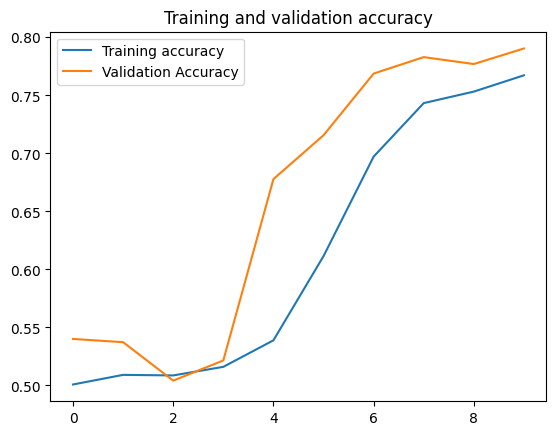

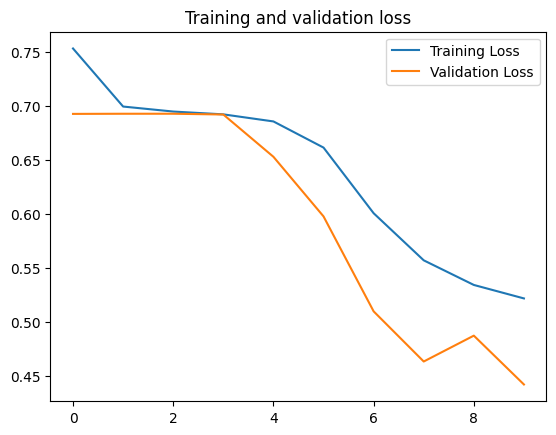

In [95]:
print('Dropout Model')
plot_acc_val(history_dropout)

Flatten Model


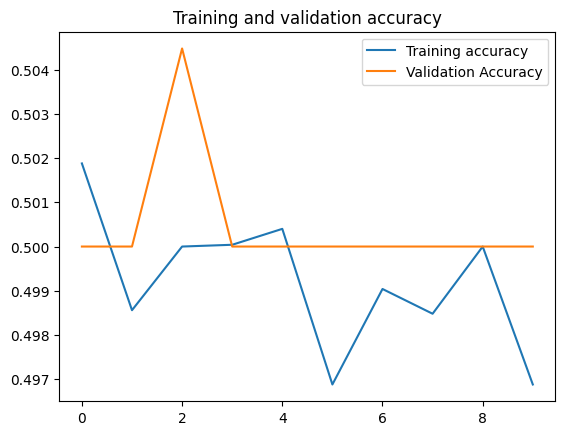

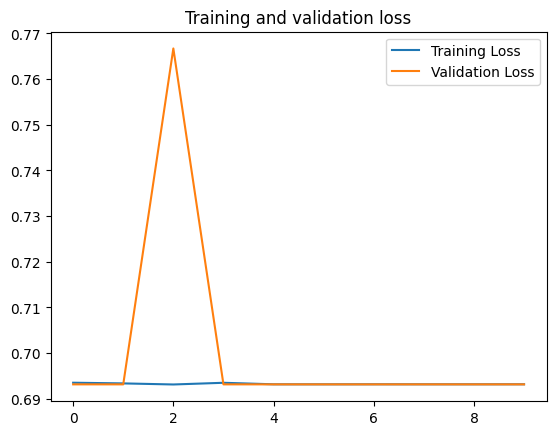

In [96]:
print('Flatten Model')
plot_acc_val(history_flatten)

LSTM Model


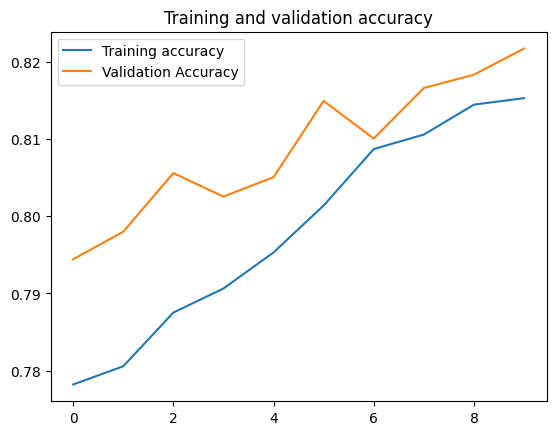

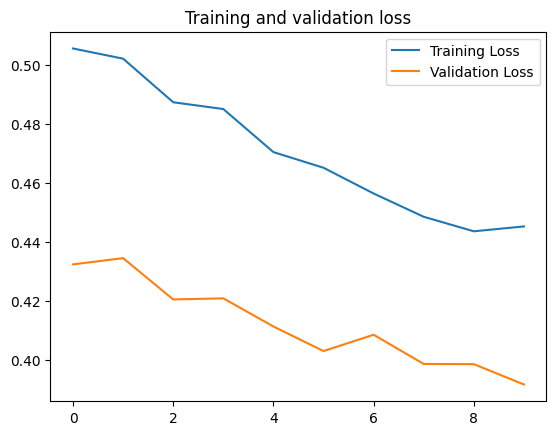

In [97]:
print('LSTM Model')
plot_acc_val(history_lstm)

GRU Model


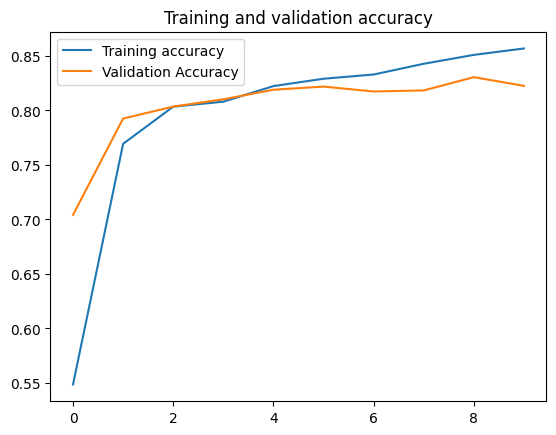

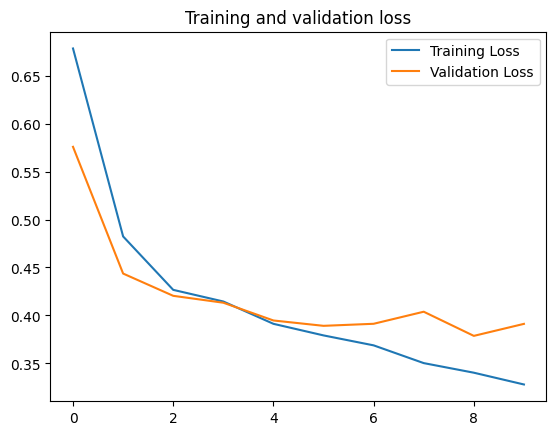

In [98]:
print('GRU Model')
plot_acc_val(history_gru)

Conv1D Model


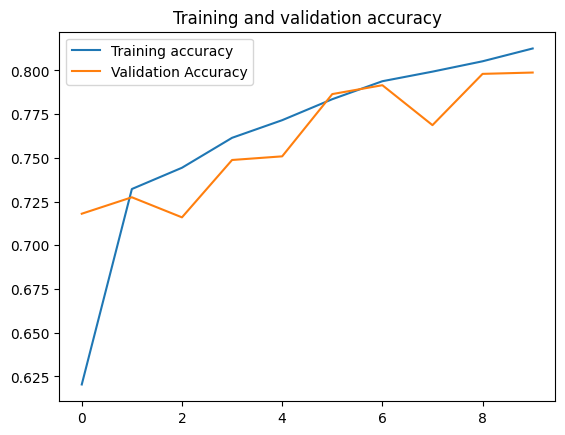

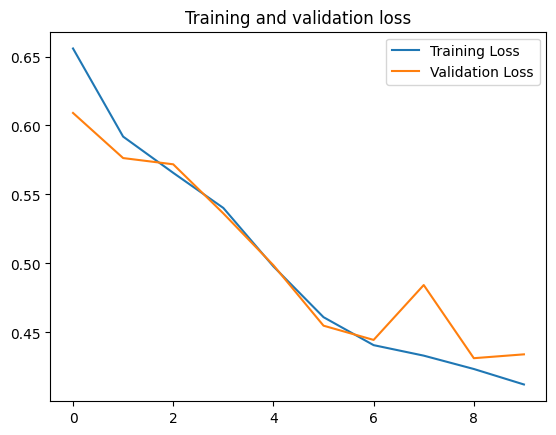

In [99]:
print('Conv1D Model')
plot_acc_val(history_conv)